<a href="https://colab.research.google.com/github/JeonghwaLee-TwinDAD/Boiler-Sequence/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start building model

In [264]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [265]:
DATA_DIR = './data/'
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
KEEP_PROB = 0.5
EPOCHS = 100
BATCH_SIZE = 32

## load the driving log (csv format) 

In [4]:
!unzip '/content/drive/My Drive/Colab Notebooks/CarND/CarND-Behavioral-Cloning/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2016_12_01_13_42_28_400.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_400.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_502.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_502.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_604.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_604.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_705.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_705.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_806.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_806.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_906.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_906.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_007.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_29_007.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_109.jpg  
  

In [266]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv(os.path.join(DATA_DIR, 'driving_log.csv'))

lines = df.to_dict('index')
train_samples, valid_samples = train_test_split(lines, test_size=0.2)

n_train= len(train_samples)
n_valid = len(valid_samples)

print('Number of train data : ', n_train)
print('Number of validation data : ', n_valid)

Number of train data :  6428
Number of validation data :  1608


## Sample images

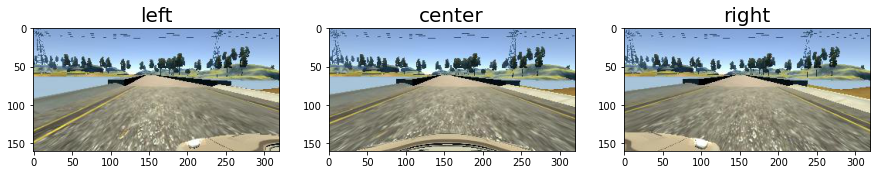

In [267]:
import random

index = np.sum(random.sample(range(0, n_train),1))
line = train_samples[index]

fig, axs = plt.subplots(1,3, figsize=(15,5))

left_img_path = line['left'].strip()
center_img_path = line['center'].strip()
right_img_path = line['right'].strip()

left_img_path = os.path.join(DATA_DIR, left_img_path)
left_img = plt.imread(left_img_path)
axs[0].imshow(left_img.squeeze())
axs[0].set_title('left',fontsize=20)

center_img_path = os.path.join(DATA_DIR, center_img_path)
center_img = plt.imread(center_img_path)
axs[1].imshow(center_img.squeeze())
axs[1].set_title('center',fontsize=20)

right_img_path = os.path.join(DATA_DIR, right_img_path)
right_img = plt.imread(right_img_path)
axs[2].imshow(right_img.squeeze())
axs[2].set_title('right',fontsize=20)

plt.show()

## Preprocessing (Crop, Resize, YUV convert)

In [268]:
import cv2

def preprocess(image):
    # remove the sky and the car front
    image = image[50:-20, :, :] 
    # Resize the image to the input shape used by the network model
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    #Convert the image from RGB to YUV (This is what the NVIDIA model does)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    return image

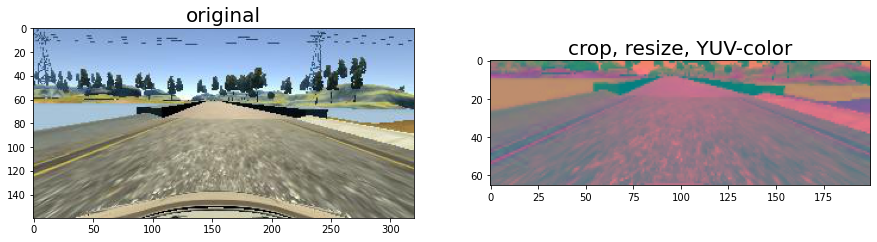

In [269]:
sample_image = plt.imread(center_img_path)
process_image = preprocess(sample_image)

fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].imshow(sample_image.squeeze())
axs[0].set_title('original',fontsize=20)

axs[1].imshow(process_image.squeeze())
axs[1].set_title('crop, resize, YUV-color',fontsize=20)

plt.show()

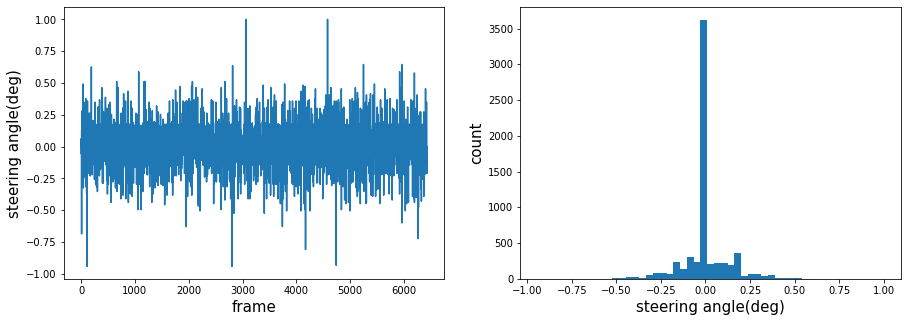

In [270]:
# Get steering angles from train samples
train_steering_angles = list(item['steering'] for item in train_samples)

fig, axs = plt.subplots(1,2, figsize=(15, 5))

# plot data
axs[0].plot(train_steering_angles)
axs[0].set_xlabel('frame', fontsize = '15')
axs[0].set_ylabel('steering angle(deg)', fontsize = '15')

# plot histogram
axs[1].hist(train_steering_angles, bins=51)
axs[1].set_xlabel('steering angle(deg)', fontsize = '15')
axs[1].set_ylabel('count', fontsize = '15')

plt.show()



## Set data augmentation

In [271]:
import matplotlib.image as mpimg
import sklearn

np.random.seed(0)

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def choose_image(data_dir, line):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, line['left']), line['steering'] + 0.2
    elif choice == 1:
        return load_image(data_dir, line['right']), line['steering'] - 0.2
    return load_image(data_dir, line['center']), line['steering']

def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def augument(data_dir, line, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, line)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_brightness(image)
    return image, steering_angle

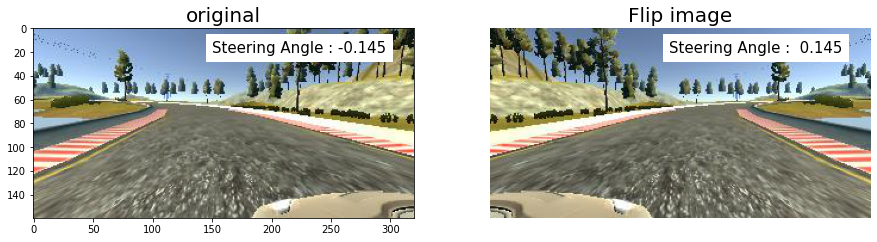

In [274]:
index = np.sum(random.sample(range(0, n_train),1))

original_image = load_image(DATA_DIR, train_samples[index]['left'])
steering_angle = train_samples[index]['steering']
flip_image, flip_steering_angle = random_flip(original_image, steering_angle)   
translate_image, translate_steering_angle = random_translate(original_image, steering_angle, range_x=100, range_y=100)   

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')
axs[0].text(150,20,'Steering Angle : {: 0.3f}'.format(steering_angle),
            backgroundcolor = 'white', fontsize=15)

axs[1].imshow(flip_image)
axs[1].set_title('Flip image',fontsize=20)
axs[1].axis('off')
axs[1].text(150,20,'Steering Angle : {: 0.3f}'.format(flip_steering_angle),
            backgroundcolor = 'white', fontsize=15)

plt.show()

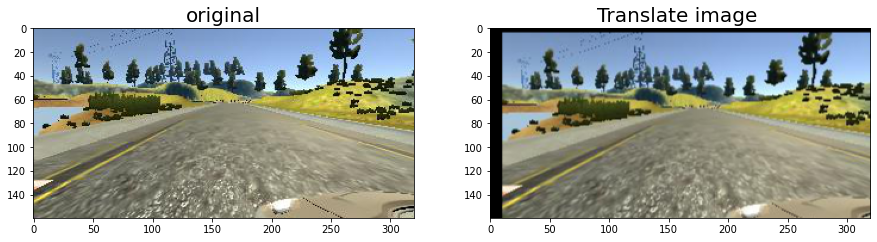

In [273]:
index = np.sum(random.sample(range(0, n_train),1))

original_image = load_image(DATA_DIR, train_samples[index]['left'])
translate_image, translate_steering_angle = random_translate(original_image, steering_angle, range_x=100, range_y=100)   

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')

axs[1].imshow(translate_image)
axs[1].set_title('Translate image ',fontsize=20)
axs[1].axis('on')

plt.show()

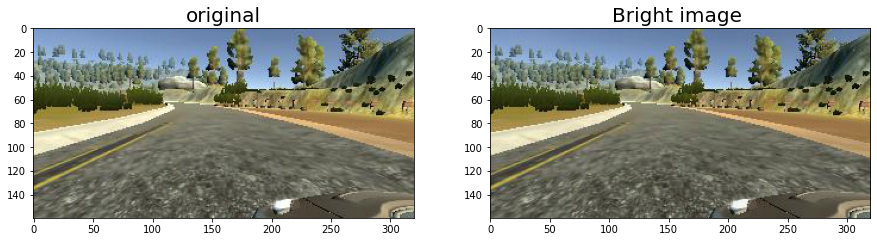

In [275]:
index = np.sum(random.sample(range(0, n_train),1))

original_image = load_image(DATA_DIR, train_samples[index]['left'])
bright_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')

axs[1].imshow(bright_image)
axs[1].set_title('Bright image ',fontsize=20)
axs[1].axis('on')

plt.show()

## Get a generator not to store all the values in memory

In [278]:
from sklearn.utils import shuffle

def generator(data_dir, samples, batch_size=BATCH_SIZE, is_training='True'):
    """
    Generate the required images and measurments for training/
    """
    images = []
    angles = []

    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        batch_samples = samples[0:batch_size]

        #for offset in range(0, num_samples, batch_size):
        for index, batch_line in enumerate(batch_samples):
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, batch_line)
            else:
                image = load_image(data_dir, batch_line['center'])
                steering_angle = batch_line['steering']
            # Add the images and steering angles to the list
            images.append(preprocess(image))
            angles.append(steering_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

### Build the modified NVIDIA model 

In [279]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24,(5, 5), activation='elu', strides=(2, 2)))#, padding='same'))
model.add(Conv2D(36,(5, 5), activation='elu', strides=(2, 2)))#, padding='same'))
model.add(Conv2D(48,(5, 5), activation='elu', strides=(2, 2)))#, padding='same'))
model.add(Conv2D(64,(3, 3), activation='elu'))#, padding='same'))
model.add(Conv2D(64,(3, 3), activation='elu'))#, padding='same'))
model.add(Dropout(KEEP_PROB))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 18, 64)        

### Run training

In [280]:
from math import ceil

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only='true',
                             mode='auto')

earlystopping = EarlyStopping(monitor='val_loss', 
                            patience=0, 
                            verbose=0, 
                            mode='auto')


# Mean Squared Error(MSE) for the loss function and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Training data generator
train_generator = generator(DATA_DIR, train_samples, BATCH_SIZE, 'True')

# Validation data generator
valid_generator = generator(DATA_DIR, valid_samples, BATCH_SIZE, 'False')

history_object = model.fit(train_generator, 
                  steps_per_epoch=ceil(n_train/BATCH_SIZE),
                  validation_data=valid_generator, 
                  validation_steps=ceil(n_valid/BATCH_SIZE),
                  epochs = EPOCHS,
                  callbacks=[checkpoint, earlystopping],
                  verbose=1,
                  shuffle = 1)

with open(os.path.join(DATA_DIR, 'model.json'), 'w') as file:
    file.write(model.to_json())

Epoch 1/100
201/201 [==============================] - 12s 62ms/step - loss: 0.0113 - val_loss: 0.0361
Epoch 2/100
201/201 [==============================] - 21s 106ms/step - loss: 0.0059 - val_loss: 0.0376


## plot the training and validation loss for each epoch

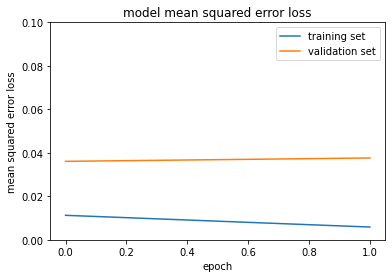

In [283]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.ylim(0, 0.1)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()